In [11]:
import NNlib: softmax
using CairoMakie
using DataFrames
using Distributions
using Optim, NLSolversBase

In [12]:
include("../src/PlotFunctions.jl")

plot_post_pred_seq_counts_HDI (generic function with 1 method)

# Are frequency growth rates the same as epidemic growth rates?



In what follows, we assume that the frequency of different variants in a population can be written as

$$
f_{v}(t) =  \frac{I_{v}(t)}{\sum_{1\leq i \leq V} I_{i}(t)}, 
$$

where $f_{v}(t)$ is the frequency of variant $v$ and $I_{v}(t)$ are the true infections of variant $v$. Under the multinomial logistic regression, we write this as

$$
f_{v}(t) = \frac{\exp(\beta_{0, v} + \beta_{1, v_\star} t)}{\sum_{1\leq i \leq V} \exp(\beta_{0, i} + \beta_{1, i} t)}
$$


Essentially, this means that the dynamics of actual active infections in each variant are described by:

$$
I_{v}(t) = I(t) \cdot f_{v}(t)
$$

since the frequency are defined up to a constant. Similarly, we have that

$$
I(t) = \sum_{1\leq v \leq V} I_{v}(t)
$$

Using the product rule, we can compute the derivative of the lineage specific infections as
$$
\frac{d I_{v}}{dt} = f_{v} \cdot \frac{dI}{dt} +  I \cdot \frac{d f_{v}}{dt},
$$

We can also compute the derivative of its frequency as
$$
\frac{d f_{v}}{dt} = \frac{I_{v}' I - I_{v} I'}{I^2}
$$

## Deriving the change in frequency over time

Using 

$$
f_{v_\star}(t) = \frac{\exp(\beta_{0, v} + \beta_{1, v_\star} t)}{\sum_{1\leq v \leq V} \exp(\beta_{0, v} + \beta_{1, v} t)}, 
$$

Let's call $g_v(t) = \exp(\beta_{0,v} + \beta_{1,v} t)$. We have that $g_v'(t) = \beta_{1,v} g_v(t)$. Therefore by quotient rule we have that

$$
\frac{df_{v}}{dt} = \frac{ \beta_{1,v} g_v (\sum_i g_i) - g_v (\sum_i \beta_{1,i} g_i)}{(\sum_{i} g_i)^2}\\
= \frac{\sum_i ( \beta_{1,v} - \beta_{1, i})( g_i g_v ) }{(\sum_{i} g_i)^2}\\
= f_v \cdot \frac{ \sum_i(\beta_{1,v} - \beta_{1,i}) g_i}{\sum_i g_i}\\
= f_v \cdot \sum_i (\beta_{1,v} - \beta_{1,i}) f_i
$$

## Estimating lineage specific prevalence

Using this estimate for $df/dt$, we have the lineage specific growth rate can be written as

$$
\frac{dI_{v}}{dt} =  f_{v} \cdot \frac{dI}{dt} +  I \cdot \frac{d f_{v}}{dt}\\
= f_{v}\frac{dI}{dt} + I \left(f_v \cdot \sum_i (\beta_{1,v} - \beta_{1,i}) f_i\right)\\
= f_{v} \left(\frac{dI}{dt} + I \sum_i (\beta_{1,v} - \beta_{1,i}) f_i \right)\\
= f_{v}\frac{dI}{dt} + I_v \sum_i (\beta_{1,v} - \beta_{1,i}) f_i\\
= f_{v} \sum_{i} \frac{dI_i}{dt}+ I_v \sum_i (\beta_{1,v} - \beta_{1,i}) f_i\\
$$



If we specify that $dI/dt = r(t) I$, we then have that $\sum_{i} \frac{dI_i}{dt} = r(t) I$, so that

$$
\frac{dI_{v}}{dt} = f_{v} r(t) I + I_v \sum_i (\beta_{1,v} - \beta_{1,i}) f_i\\
\frac{dI_{v}}{dt} = I_v \left( r(t)+ \sum_{i} (\beta_{1,v} - \beta_{1,i}) f_i\right)\\
\frac{dI_{v}}{dt} = f_v I \left( r(t)+ \sum_{i} (\beta_{1,v} - \beta_{1,i}) f_i\right)\\
$$

This shows that we can parameterize the growth of lineages using only their frequencies and the growth rate of their sum.

## Using frequency growth what can we say about overall growth?

$$
\frac{dI_{v}}{dt} / \frac{dI_{u}}{dt} = \frac{f_v}{f_u} \left( \frac{r(t)+ \sum_{i} (\beta_{1,v} - \beta_{1,i}) f_i}{r(t)+ \sum_{i} (\beta_{1,u} - \beta_{1,i}) f_i} \right)
$$

Consider the difference of the per-capita growth rates:

$$
\frac{1}{I_v}\frac{dI_{v}}{dt} - \frac{1}{I_u}\frac{dI_{u}}{dt} = \sum_{i} (\beta_{1,v} - \beta_{1,i}) f_i - \sum_{i} (\beta_{1,u} - \beta_{1,i}) f_i\\
= \sum_{i} (\beta_{1, v} - \beta_{1, u}) f_i = \beta_{1,v} - \beta_{1,u}
$$

It is the difference of beta which determines the growth rate difference not the quotient?

## Final Equations

We have two sets of equations 

$$
\frac{df_v}{dt} = f_v \cdot \sum_i (\beta_{1,v} - \beta_{1,i}) f_i\\
\frac{dI}{dt} = r(t) I \\
\implies\\
\frac{dI_{v}}{dt} = f_v I \left( r(t)+ \sum_{i} (\beta_{1,v} - \beta_{1,i}) f_i\right)\\
$$

We can solve first equation with multinomial logistic regression and with case data learn $r(t)$, but overall this isn't particularly useul as this is not $R(t)$ but $r(t)$ a growth rate. There are several ways of converting this:

1. We can say that $r(t) = \beta S(t)-\gamma$, so that $(r(t)/ 
\gamma + 1) = \beta S(t) / \gamma = R_t$ corresponding to an SIR model.

2. Alternatively, we can assume that we have a fixed generation time $T_{g}$, in which case $R_{t} = \exp(r(t) T_{g})$

To turn these into lineage specific growth rates, we see that for $I_v$, 

$$
r_v(t) =  r(t)+ \sum_{i} (\beta_{1,v} - \beta_{1,i}) f_i)
$$

We then have that in case one:

$$
R_{t,v} =  \frac{r(t) + \sum_{i} (\beta_{1,v} - \beta_{1,i}) f_i}{\gamma} + 1
$$

This does not render a nice formula for the ratio of reproductive rates.

On the other hand, in case 2, we have that

$$
\log R_{t,v} =  [r(t) + \sum_{i} (\beta_{1,v} - \beta_{1,i}) f_i] * T_{g}
$$

In which case

$$
\log [R_{t, v} / R_{t, u}] =  (\beta_{1,v} - \beta_{1,i}) * T_{g}
$$

In [13]:
using DataFrames, CSV, Dates

df = CSV.read("../data/raw/cases-lineage-sequence-counts-2021-09-23.tsv", DataFrame)
first(df, 10)

,state,date,cases,sequences_total,sequences_other,sequences_B.1.1.7
,String,Date,Int64,Int64,Int64,Int64
1,Alabama,2021-01-28,2340,0,0,0
2,Alabama,2021-01-29,1967,5,5,0
3,Alabama,2021-01-30,1253,0,0,0
4,Alabama,2021-01-31,1228,1,1,0
5,Alabama,2021-02-01,2476,15,13,1
6,Alabama,2021-02-02,1997,17,17,0
7,Alabama,2021-02-03,1742,1,0,1
8,Alabama,2021-02-04,1649,2,2,0
9,Alabama,2021-02-05,1582,39,37,1


In [30]:
function process_data_for_MLR(input_df, SoI)
    
    df = filter(row -> row.state == SoI, input_df)
    sort!(df, :date)
    
    # Get columns with sequences in name
    seq_cols = startswith.(names(df), "sequences") .& .! endswith.(names(df), "total")
    seq_cols = names(df)[seq_cols]
    
    # Turn counts to response matrix
    Y = Matrix(df[!, seq_cols])
    freqs = Y ./ sum(Y, dims = 2)
    
    # Cases to vector
    cases = df[!, :cases]
    # Number of classes
    K = size(Y, 2)
    
    # Get total sequences per day
    N = vec(Matrix(df[!,names(df)[endswith.(names(df), "total")]]))

    # Get dates
    T = Dates.value.(df[!, :date] - df[1,:date]) 
    #T /= T[end]
    
    # Get features 
    X = [ones(size(Y,1)) T]
    input = (; X, N, K)
    output = (; Y, freqs, cases)
    
    seq_cols = replace.(seq_cols, "sequences_" => "")
    misc = (; seq_cols, T, df.date)
    return input, output, misc
end

SoI = "Washington"
input, output, misc = process_data_for_MLR(df, SoI)

((X = [1.0 0.0; 1.0 1.0; … ; 1.0 215.0; 1.0 216.0], N = [76, 105, 67, 25, 101, 213, 98, 161, 105, 76  …  150, 86, 128, 258, 258, 120, 142, 113, 39, 29], K = 8), (Y = [61 0 … 0 0; 73 3 … 0 0; … ; 0 0 … 39 0; 0 0 … 29 0], freqs = [0.8026315789473685 0.0 … 0.0 0.0; 0.6952380952380952 0.02857142857142857 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 1.0 0.0], cases = [2407, 1992, 1807, 1198, 859, 1096, 1506, 1542, 1492, 486  …  2789, 3073, 2991, 3843, 4267, 2924, 2924, 2926, 3279, 4063]), (seq_cols = ["other", "B.1.1.7", "B.1.351", "P.1", "B.1.427", "B.1.526", "B.1.617.2", "B.1.621"], T = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9  …  207, 208, 209, 210, 211, 212, 213, 214, 215, 216], date = [Date("2021-01-28"), Date("2021-01-29"), Date("2021-01-30"), Date("2021-01-31"), Date("2021-02-01"), Date("2021-02-02"), Date("2021-02-03"), Date("2021-02-04"), Date("2021-02-05"), Date("2021-02-06")  …  Date("2021-08-23"), Date("2021-08-24"), Date("2021-08-25"), Date("2021-08-26"), Date("2021-08-27"), Date("2021-08-

In [31]:
SoI_Vars = size(output.Y, 2)

SoI_obs = DataFrame(
    counts = reduce(vcat, output.Y), 
    total_count = repeat(vec(sum(output.Y, dims = 2)), outer = [SoI_Vars]), 
    freq = reduce(vcat, output.freqs), 
    cases = repeat(output.cases, outer = [SoI_Vars]), 
    t = repeat(misc.T, outer = [SoI_Vars]),
    dates = repeat(misc.date, outer = [SoI_Vars]),
    lineage = repeat(misc.seq_cols, inner = length(misc.T)),
    lineage_num = repeat(1:SoI_Vars, inner = length(misc.T))
)

first(SoI_obs, 10)

,counts,total_count,freq,cases,t,dates,lineage,lineage_num
,Int64,Int64,Float64,Int64,Int64,Date,String,Int64
1,61,76,0.802632,2407,0,2021-01-28,other,1
2,73,105,0.695238,1992,1,2021-01-29,other,1
3,51,67,0.761194,1807,2,2021-01-30,other,1
4,20,25,0.8,1198,3,2021-01-31,other,1
5,82,101,0.811881,859,4,2021-02-01,other,1
6,148,213,0.694836,1096,5,2021-02-02,other,1
7,73,98,0.744898,1506,6,2021-02-03,other,1
8,110,161,0.68323,1542,7,2021-02-04,other,1
9,76,105,0.72381,1492,8,2021-02-05,other,1


In [32]:
lineage_colors = ["#2e5eaa", "#5adbff", "#b4c5e4","#f5bb00","#56e39f",
    "#9e4244",
    "#f03a47", "#808080"]

lineage_map = Dict()
for (i, lineage) in enumerate(sort(misc.seq_cols))
    lineage_map[lineage] = i
end

lineage_vec = [lineage_colors[lineage_map[i]] for i in SoI_obs.lineage]

# seq_names to WHO
lineage_to_WHO = Dict()
lineage_to_WHO["B.1.1.7"] = "Alpha"
lineage_to_WHO["B.1.351"] = "Beta"
lineage_to_WHO["P.1"] = "Gamma"
lineage_to_WHO["B.1.617.2"] = "Delta"
lineage_to_WHO["B.1.525"] = "Eta"
lineage_to_WHO["B.1.526"] = "Iota"
lineage_to_WHO["B.1.617.1"] = "Kappa"
lineage_to_WHO["C.37"] = "Lambda"
lineage_to_WHO["other"] = "other"
lineage_to_WHO["B.1.427"] = "Epsilon"
lineage_to_WHO["B.1.621"] = "Mu"


WHO_seq_names = [lineage_to_WHO[lineage] for lineage in misc.seq_cols]

8-element Vector{String}:
 "other"
 "Alpha"
 "Beta"
 "Gamma"
 "Epsilon"
 "Iota"
 "Delta"
 "Mu"

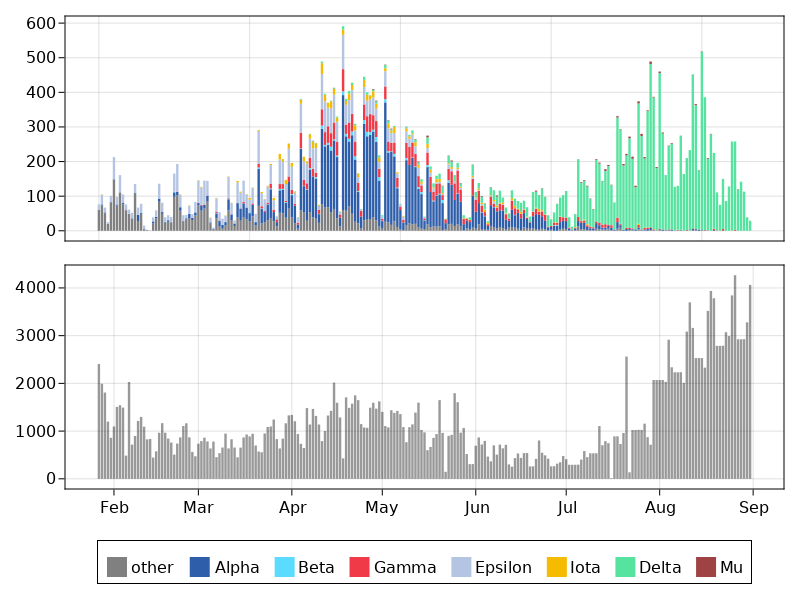

In [33]:
# Raw data

fig = Figure()
ax1 = fig[1,1] = Axis(fig)

barplot!(ax1, SoI_obs.t, SoI_obs.counts, 
    stack = SoI_obs.lineage_num,
    color =  lineage_vec)


ax2 = fig[2,1] = Axis(fig)

barplot!(ax2, misc.T, output.cases, 
    color = (:black, 0.4)
    )

# Axis Decorations
hidexdecorations!(ax1, grid = false)
linkxaxes!(ax1, ax2)
ticks, _ = get_nice_ticks(misc.date)
ax2.xticks = ticks
ax2.xtickformat = xs -> Dates.monthabbr.(misc.date[convert.(Int, xs)])

# Legend
elements = [PolyElement(polycolor = lineage_colors[lineage_map[l]]) for l in misc.seq_cols]
fig[3,1] = Legend(fig, elements, WHO_seq_names, "", orientation = :horizontal, tellwidth = false, tellheight = true)
fig


## Fitting the multinomial logistic regression

In [34]:
"""
Given growth coeffiencents β and time points t, 
simulate the frequency of variants 
under multinomial logistic regression
"""
function simulate_frequencies(β, t) 
    X = [ones(size(t, 1)) t] # Design matrix [1 t]
    Xβ = X * [β zeros(size(X, 2))] # Add pivot col
    return softmax(Xβ, dims = 2) # Transform to frequencies
end

simulate_frequencies

In [35]:
# Make predictor matrix
function make_X(t)
    X = [ones(size(t, 1)) t] 
end

# Define likelihood
ll_Multinomial(Y, P) = sum(Y) > 0 ? logpdf(Multinomial(sum(Y), P), Y) : 0

function ll_MLR(Y, X, β)
    # Use last dimension as reference
    P = softmax(X * [β zeros(size(X, 2))], dims = 2)
    return -sum(ll_Multinomial(Y[i,:], P[i, :]) for i in 1:size(X,1))
end

function run_MLR(Y, X)
    β_size = (size(X, 2), size(Y,2)-1)
    nβ = prod(β_size)
    
    func = TwiceDifferentiable(
        β -> ll_MLR(Y, X, reshape(β, β_size)), 
        ones(nβ); 
        autodiff=:forward)
    
    opt = optimize(func, ones(nβ))
    return opt, reshape(Optim.minimizer(opt), β_size)
end

run_MLR (generic function with 1 method)

In [36]:
opt, β_MLR = run_MLR(output.Y, input.X)
freq_MLR = simulate_frequencies(β_MLR, misc.T) # Is there a way to make this more consistent?
SoI_obs.freq_MLR = reduce(vcat, freq_MLR) # Add column w
opt

 * Status: success

 * Candidate solution
    Final objective value:     3.394699e+03

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 1.46e-11 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.06e-12 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.73e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.04e-16 ≰ 0.0e+00
    |g(x)|                 = 1.33e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    10
    f(x) calls:    41
    ∇f(x) calls:   41
    ∇²f(x) calls:  10


### Converting the time-varying growth-rate to Rt

Assuming that we have a fixed generation time $T_{g}$, we can turn the growth rate into an estimate of the effective reproductive number:
$$
R_{t} = \exp(r(t) T_{g}).
$$




## Combining epidemic growth rates and frequency estimates

We can now write the epidemic growth rate of variant $v$ as

$$
r_v(t) =  r(t)+ \sum_{i} (\beta_{1,v} - \beta_{1,i}) f_i).
$$

Under the same generation time assumption, we have that then the variant specific Rt can be written as 

$$
\log R_{t,v} =  [r(t) + \sum_{i} (\beta_{1,v} - \beta_{1,i}) f_i] * T_{g}.
$$

In which case, the log ratio of reproductive numbers can be written as:

$$
\log [R_{t, v} / R_{t, u}] =  (\beta_{1,v} - \beta_{1,i}) * T_{g}
$$


In [37]:
function get_R_ratios(β, Tg)
   return (β[2,:]' .- β[2,:]) * Tg
end

# Fixed generation time
Tg = 5.5

# Compute R ratios
R_ratios =  get_R_ratios(hcat(β_MLR, zeros(2)), Tg)


8×8 Matrix{Float64}:
  0.0         0.232647    0.187739   …   0.215928   0.706389   0.544938
 -0.232647    0.0        -0.0449083     -0.0167187  0.473742   0.312291
 -0.187739    0.0449083   0.0            0.0281896  0.518651   0.357199
 -0.294484   -0.0618369  -0.106745      -0.0785556  0.411905   0.250454
 -0.0304814   0.202166    0.157257       0.185447   0.675908   0.514456
 -0.215928    0.0167187  -0.0281896  …   0.0        0.490461   0.329009
 -0.706389   -0.473742   -0.518651      -0.490461   0.0       -0.161452
 -0.544938   -0.312291   -0.357199      -0.329009   0.161452   0.0

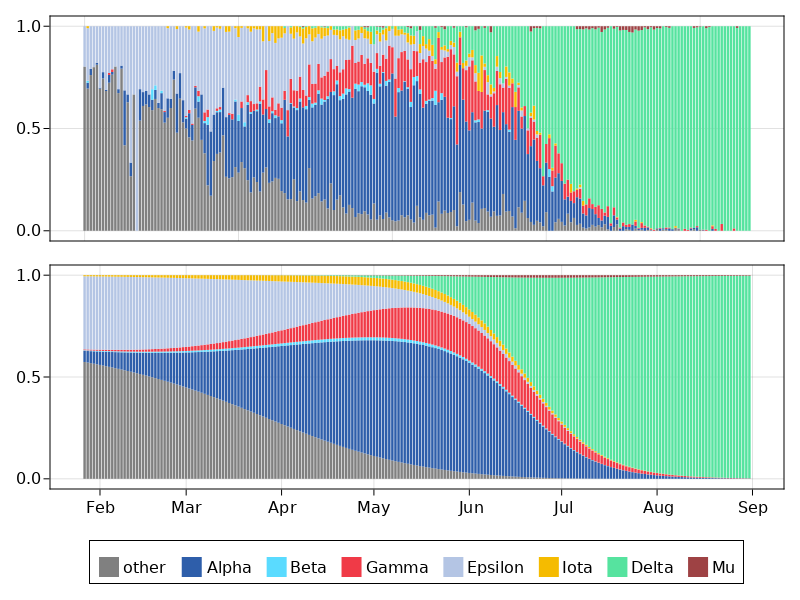

In [38]:
fig = Figure()
ax1 = fig[1,1] = Axis(fig)

barplot!(ax1, SoI_obs.t, SoI_obs.freq, 
    stack = SoI_obs.lineage_num,
    color =  lineage_vec)

ax2 = fig[2,1] = Axis(fig)

barplot!(ax2, SoI_obs.t, SoI_obs.freq_MLR, 
    stack = SoI_obs.lineage_num,
    color =  lineage_vec)

# Axis Decorations
hidexdecorations!(ax1, grid = false)
linkxaxes!(ax1, ax2)
ticks, _ = get_nice_ticks(misc.date)
ax2.xticks = ticks
ax2.xtickformat = xs -> Dates.monthabbr.(misc.date[convert.(Int, xs)])

elements = [PolyElement(polycolor = lineage_colors[lineage_map[l]]) for l in misc.seq_cols]
fig[3,1] = Legend(fig, elements, WHO_seq_names, "", orientation = :horizontal, tellwidth = false, tellheight = true)
fig

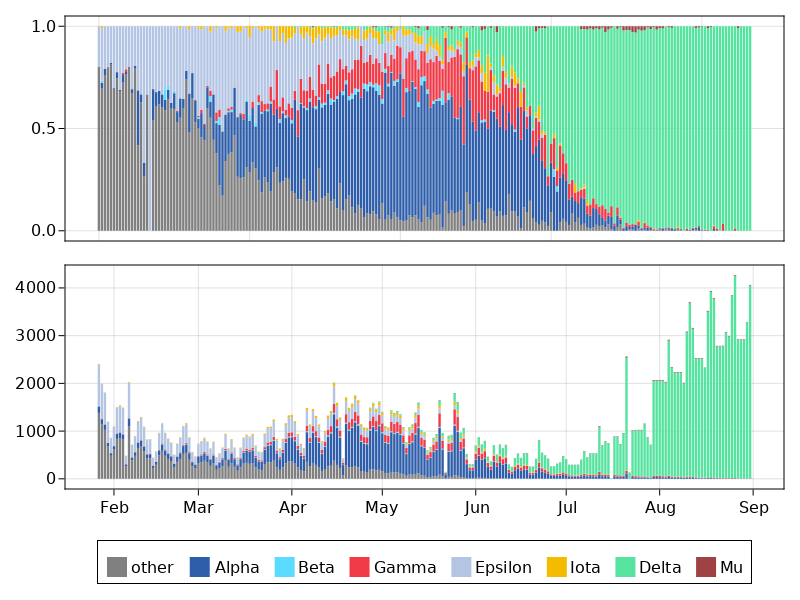

In [41]:
fig = Figure()

# Observed Frequencies
ax1 = fig[1,1] = Axis(fig)
barplot!(ax1, SoI_obs.t, SoI_obs.freq, 
    stack = SoI_obs.lineage_num,
    color =  lineage_vec)

# Lineage Disagregate Cases
ax3 = fig[2,1] = Axis(fig)
barplot!(ax3, SoI_obs.t, SoI_obs.cases .* SoI_obs.freq_MLR, 
    stack = SoI_obs.lineage_num,
    color =  lineage_vec)

# Axis Decorations
hidexdecorations!(ax1, grid = false)
ticks, _ = get_nice_ticks(misc.date)
ax3.xticks = ticks
ax3.xtickformat = xs -> Dates.monthabbr.(misc.date[convert.(Int, xs)])

# Legend
elements = [PolyElement(polycolor = lineage_colors[lineage_map[l]]) for l in misc.seq_cols]
fig[3,1] = Legend(fig, elements, WHO_seq_names, "", orientation = :horizontal, tellwidth = false, tellheight = true)

fig

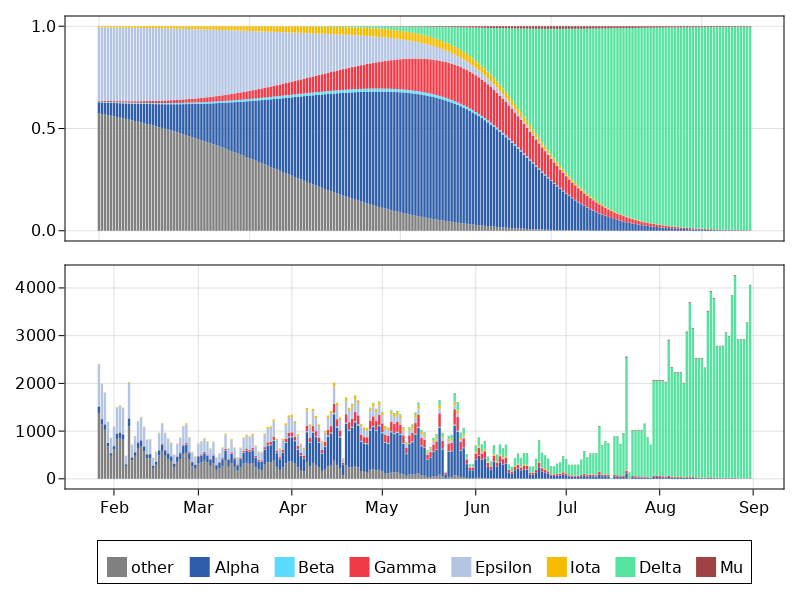

In [43]:
fig = Figure()

ax1 = fig[1,1] = Axis(fig)

barplot!(ax1, SoI_obs.t, SoI_obs.freq_MLR, 
    stack = SoI_obs.lineage_num,
    color =  lineage_vec)


ax2 = fig[2,1] = Axis(fig)
barplot!(ax2, SoI_obs.t, SoI_obs.cases .* SoI_obs.freq_MLR, 
    stack = SoI_obs.lineage_num,
    color =  lineage_vec)

# Axis Decorations
hidexdecorations!(ax1, grid = false)
ticks, _ = get_nice_ticks(misc.date)
ax2.xticks = ticks
ax2.xtickformat = xs -> Dates.monthabbr.(misc.date[convert.(Int, xs)])

elements = [PolyElement(polycolor = lineage_colors[lineage_map[l]]) for l in misc.seq_cols]
fig[3,1] = Legend(fig, elements, WHO_seq_names, "", orientation = :horizontal, tellwidth = false, tellheight = true)
fig

## Analying growth patterns across states

In [44]:
function get_state_growths(SoI, df, Tg)
    # Load data
    input, output, misc = process_data_for_model(df, SoI)
    # Run MLR
    opt, β_MLR = run_MLR(output.Y, input.X)
    #freq_MLR = simulate_frequencies(β_MLR, misc.T)
    # Get ratios
    R_ratios = exp.(get_R_ratios(hcat(β_MLR, zeros(2)), Tg)[1,:]) # First row is for other
    # Return small dataframe with cols state, lineage, growth_advantage    
    return DataFrame(
        state = SoI,
        lineage = misc.seq_cols[1:end],
        growth_advantage = R_ratios)
end

get_state_growths (generic function with 1 method)

In [45]:
# Fixed generation time
Tg = 5.5

states_list = unique(df.state)
df_list = []
Threads.@threads for state in states_list
    push!(df_list, get_state_growths(state, df, Tg))
end
df_out = vcat(df_list...)

,state,lineage,growth_advantage
,String,String,Float64
1,South Carolina,other,1.0
2,South Carolina,B.1.1.7,1.34051
3,South Carolina,B.1.351,1.16729
4,South Carolina,P.1,1.42262
5,South Carolina,B.1.427,1.02876
6,South Carolina,B.1.526,1.303
7,South Carolina,B.1.617.2,2.64391
8,South Carolina,B.1.621,2.08594
9,Connecticut,other,1.0


In [112]:
CSV.write( "../data/sims/results/09_23_21/growth_MLR_09-23-21.csv", df_out)

"growth_MLR_09-23-21.csv"

In [49]:
plot_df = filter(row -> row.lineage != "other", df_out)
plot_df.lineage_num = [lineage_map[i] for i in plot_df.lineage]
violin_cols  = [lineage_colors[lineage_map[i]] for i in plot_df.lineage];

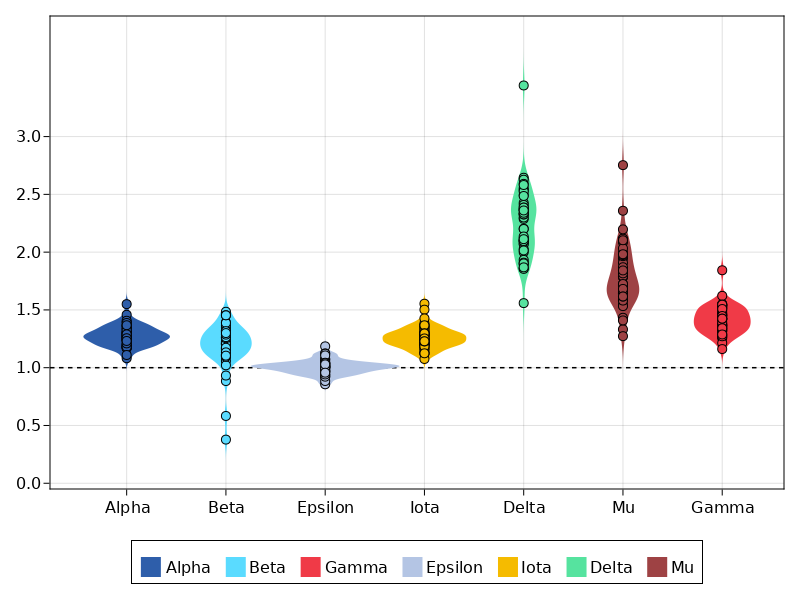

In [50]:
fig = Figure()
ax1 = fig[1,1] = Axis(fig)
hlines!(ax1, 1, linestyle = :dash, color = :black)
violin!(ax1, plot_df.lineage_num, plot_df.growth_advantage,
    color = violin_cols,
    width = 1.5)
scatter!(ax1, plot_df.lineage_num, plot_df.growth_advantage,
    color = violin_cols,
    strokewidth = 1.)

ax1.xticks = 1:7
ax1.yticks = 0.0:0.5:3.0
label_names = [ lineage_to_WHO[seq]  for seq in sort(misc.seq_cols)]
ax1.xtickformat = xs -> label_names[convert.(Int, xs)]
elements = [PolyElement(polycolor = lineage_colors[lineage_map[l]]) for l in misc.seq_cols]
fig[2,1] = Legend(fig, elements[2:end], WHO_seq_names[2:end], "", orientation = :horizontal, tellwidth = false, tellheight = true)
fig

In [83]:
# Need a rep of figure 3
function figure_3_MLR(plot_df)
    state_names = sort(unique(plot_df.state))
    clean_state_names = replace.(state_names, "_" => " ")
    states_to_ordering(state) = findfirst(s -> s==state, state_names)

    fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (2400, 2000), fontsize = 36, font = "Helvetica")
    g_growth_all = fig[1:3, 1] = GridLayout()
    ax_growth_all = Axis(g_growth_all[1,1],xlabel = "Inferred Growth Advantage")

    vlines!(ax_growth_all, [1.], color = :black, linewidth = 2.5, linestyle = :dash)

    for (lineage, name) in enumerate(misc.seq_cols[2:end])
        this_color = lineage_colors[lineage_map[name]]
        this_lineage = filter(row -> row.lineage == name, plot_df)
    
        # Plot median
        scatter!(ax_growth_all, 
            this_lineage.growth_advantage, 
            states_to_ordering.(this_lineage.state), 
            color = this_color,
            strokewidth = 3.5,
            markersize = 18.)
    end

    ax_growth_all.xticks = 0:0.5:3
    ax_growth_all.yticks = 1:length(state_names)
    ax_growth_all.ytickformat = ys -> clean_state_names[convert.(Int,ys)]
    ax_growth_all.yreversed = true

    # Growth Advantage medians
    g_growth_meds = fig[1, 2] = GridLayout()
    ax_growth_meds = Axis(g_growth_meds[1,1],ylabel = "Median Growth Advantage")
    
    hlines!(ax_growth_meds, 1, color = :black, linewidth = 2.5, linestyle = :dash)
    lineage_nums = [lineage_map[lin] for lin in plot_df.lineage]
    lineage_cols = [lineage_colors[lin] for lin in lineage_nums]
    
    violin!(ax_growth_meds, plot_df.lineage_num, plot_df.growth_advantage,
        color = violin_cols,
        width = 1.5)
    scatter!(ax_growth_meds, plot_df.lineage_num, plot_df.growth_advantage,
        color = violin_cols,
        strokewidth = 1.)

    ax_growth_meds.xticks = 1:length(misc.seq_cols)
    ax_growth_meds.yticks = 0.0:0.5:3.5
    label_names = [ lineage_to_WHO[seq]  for seq in sort(misc.seq_cols)]
    ax_growth_meds.xtickformat = xs -> label_names[convert.(Int, xs)]
    
    # Adding legend
    elements = [PolyElement(polycolor = lineage_colors[lineage_map[l]]) for l in misc.seq_cols]
    fig[2,2] = Legend(fig, elements, WHO_seq_names, "", orientation = :horizontal, tellwidth = false, tellheight = true)

    for (label, layout) in zip(["a", "b"], [g_growth_all, g_growth_meds])
    Label(layout[1, 1, TopLeft()], label,
        textsize = 50,
        padding = (0, 5, 5, 0),
        font = "Helvetica Bold",
        halign = :right)
    end
    fig 
end

figure_3_MLR (generic function with 1 method)

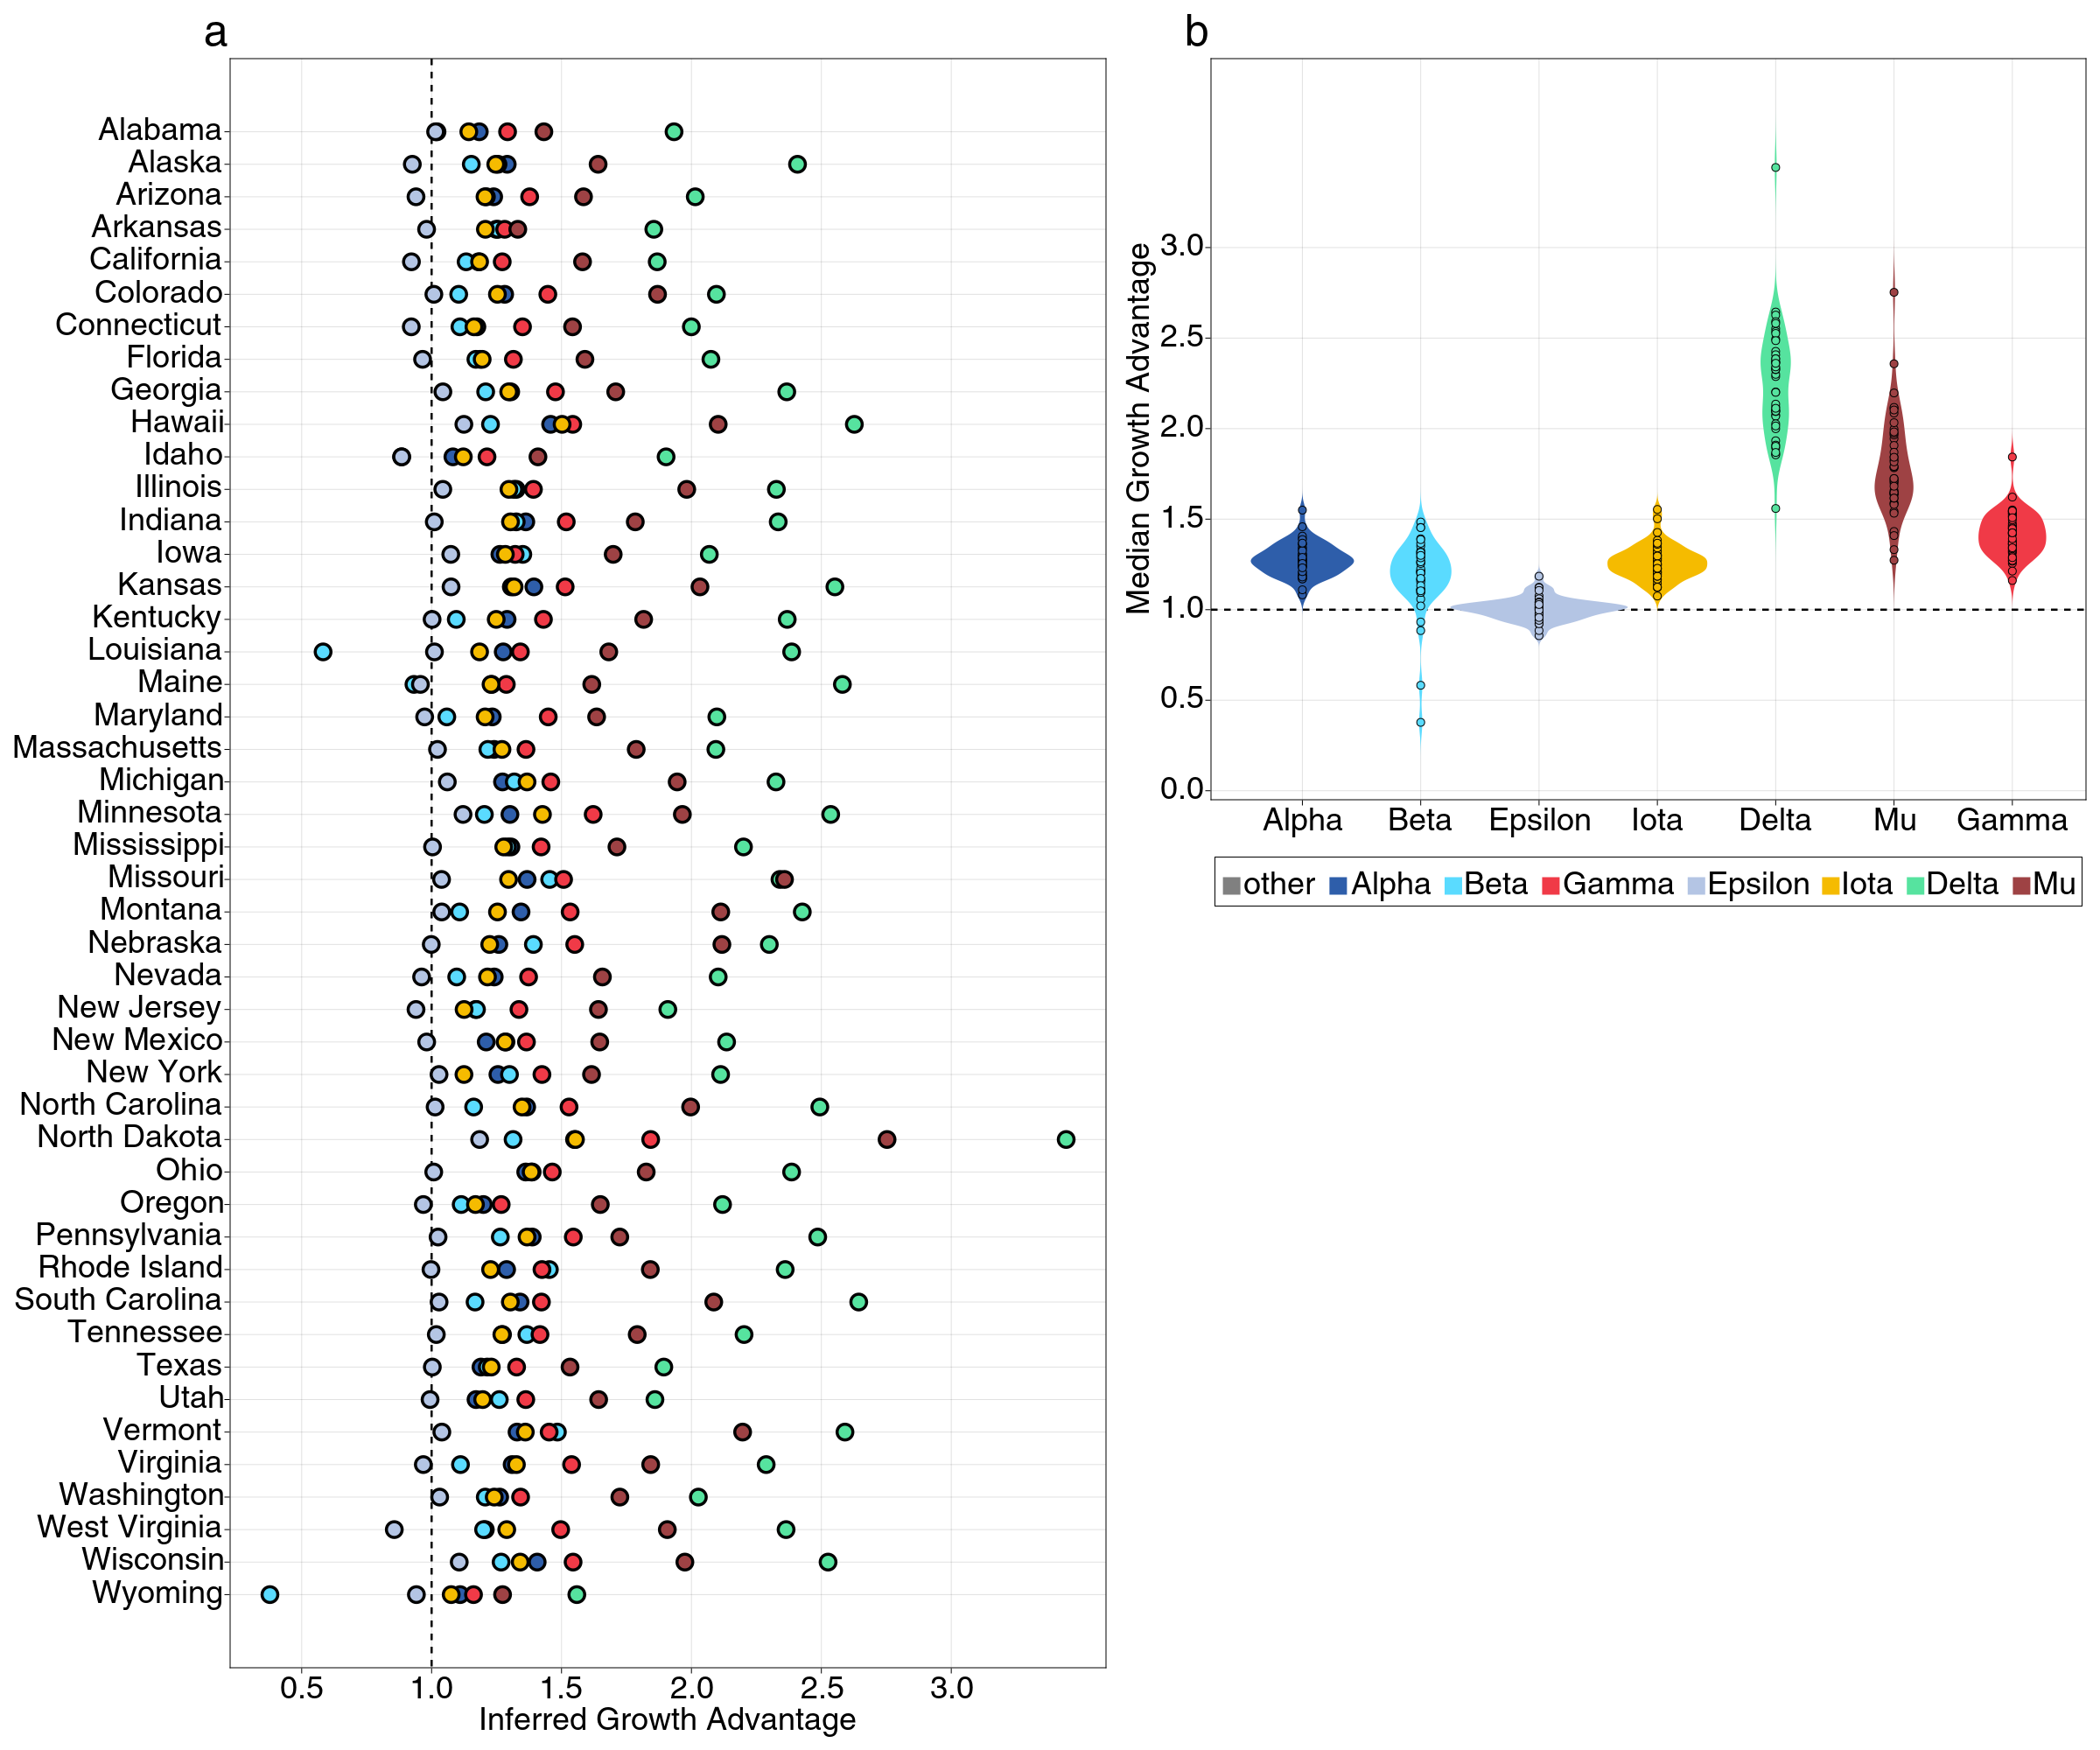

In [89]:
fig_MLR_supp = figure_3_MLR(plot_df)
save("../manuscript/figs/fig_MLR_growth_advantages_supp.png", fig_MLR_supp)
fig_MLR_supp

## Bootstrap Resampling for parameter uncertainity

In [141]:
function resample_lineage_counts(Y, num_bootstraps)
    Y_bootstrap = zeros(Int, size(Y)...,  num_bootstraps)
    for (i, row) in enumerate(eachrow(Y))
        N = sum(row)
        if N > 0
            freq =  row ./ N
            row_dist = Multinomial(N, freq)
            for bs in 1:num_bootstraps
                Y_bootstrap[i, :, bs] = rand(row_dist)
            end
        end
    end 
    return Y_bootstrap
end

function fit_resamples(df, SoI, Tg, num_bs)
    # Load data and create resamples
    input, output, misc = process_data_for_model(df, SoI)
    _, num_lineages = size(output.Y)
    Y_bs = resample_lineage_counts(output.Y, num_bs)
    R_ratios = Vector{Vector{Float64}}(undef, num_bs)
    
    #for bs in 1:num_bs
    Threads.@threads for bs in 1:num_bs
        # Run MLR and get ratios
        _, β_MLR = run_MLR(Y_bs[:,:, bs], input.X)
        R_ratios[bs] = exp.(get_R_ratios(hcat(β_MLR, zeros(2)), Tg)[1,:])
    end
    return transpose(reduce(hcat, R_ratios))
end

R_ratios = fit_resamples(df, "New York", Tg, 300)

300×8 transpose(::Matrix{Float64}) with eltype Float64:
 1.0  1.25501  1.29492  1.4129   1.03805  1.12523  2.12363  1.61887
 1.0  1.25962  1.30442  1.41379  1.02705  1.1279   2.10344  1.62283
 1.0  1.26113  1.33991  1.42829  1.03162  1.12812  2.14197  1.64234
 1.0  1.25013  1.29922  1.41597  1.02109  1.12214  2.10199  1.60205
 1.0  1.2551   1.32074  1.42669  1.0317   1.12423  2.14794  1.62758
 1.0  1.25546  1.31791  1.42454  1.0357   1.12447  2.12667  1.61639
 1.0  1.2429   1.28537  1.40799  1.01824  1.11241  2.06399  1.59771
 1.0  1.26661  1.30533  1.44287  1.04393  1.12838  2.14263  1.62189
 1.0  1.24974  1.30625  1.41633  1.02983  1.12167  2.13514  1.60971
 1.0  1.25144  1.28397  1.42124  1.01689  1.12425  2.10638  1.60211
 1.0  1.24763  1.27004  1.41515  1.03104  1.12108  2.10426  1.60422
 1.0  1.25582  1.3251   1.41928  1.03002  1.12953  2.11254  1.62402
 1.0  1.25937  1.3144   1.43648  1.02669  1.12362  2.11167  1.61598
 ⋮                                        ⋮                 

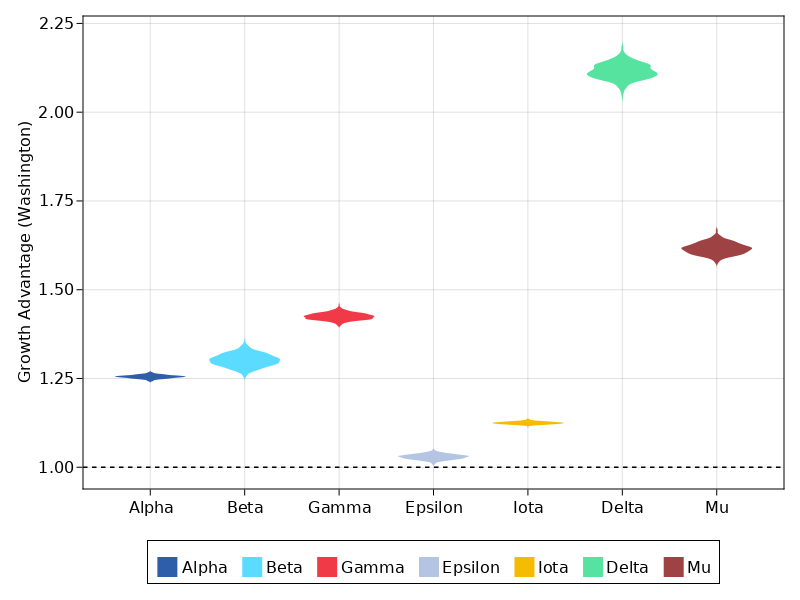

In [142]:
fig = Figure()
violin_cols = [lineage_colors[lineage_map[l]] for l in misc.seq_cols]

ax1 = fig[1,1] = Axis(fig, ylabel = "Growth Advantage ($SoI)")
hlines!(ax1, 1, linestyle = :dash, color = :black)
for lineage in 2:size(R_ratios, 2)
    violin!(ax1, fill(lineage, size(R_ratios, 1)), 
        R_ratios[:, lineage],
        color = violin_cols[lineage],
        width = 0.75)
end

ax1.xticks = 1:8
ax1.yticks = 0.0:0.25:3.0
label_names = [ lineage_to_WHO[seq] for seq in misc.seq_cols]
ax1.xtickformat = xs -> label_names[convert.(Int, xs)]
elements = [PolyElement(polycolor = lineage_colors[lineage_map[l]]) for l in misc.seq_cols]
fig[2,1] = Legend(fig, elements[2:end], WHO_seq_names[2:end], "", orientation = :horizontal, tellwidth = false, tellheight = true)
fig

# Takeaways:

- We showed that multinomial logistic regression can be used to smooth frequencies
- By imposing a differential equation of the total infections, we can interpret the coefficients as diferences in per-capita growth rates
- By assuming the generation time is fixed (Dirac Delta), we can then [Wallinga, Lipsitch?] see that R_v / R for variants is constant and can be inferred without case data.

- If we additionally have case data, we can learn the actual values of R themselves using a spline fit to daily new cases.
- We then apply this method to various states in the US to see if there are any consistent growth advantanges.

Further work is needed to investigate the value of the dirac delta assumption and whether these differences can be used to explain fitness benefits of particular mutations.

We find this is sensitive to the choice of Tg